<a href="https://colab.research.google.com/github/BrunoBVR/DL-with-python/blob/main/3p6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting house prices: a regression example

---

## Loading the Boston housing dataset

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [2]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


As you can see, you have 404 training samples and 102 test samples, each with 13 numerical features, such as per capita crime rate, average number of rooms per dwelling, accessibility to highways, and so on.

The targets are the median values of owner-occupied homes, in thousands of dollars:

In [3]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

The prices are typically between \$10,000 and \$50,000. If that sounds cheap, remember that this was the mid-1970s, and these prices aren't adjusted for inflation.

## Preparing the data (normalization)

In [4]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

Note that the quantities used for normalizing the test data are computed using the training data. You should never use in your workflow any quantity computed on the test data, even for something as simple as data normalization.

## Building the network

In general, the less training data you have, the worse overfitting will be, and using a small network is one way to mitigate overfitting.

In [5]:
from keras import models, layers

# Because we'll instantiate the same model multiple times, we use a function to build it
def build_model():
  model = models.Sequential()

  # Input layer
  model.add(layers.Dense(64, activation='relu',
                         input_shape = (train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  # Output layer -> 1 float value
  model.add(layers.Dense(1))

  # Compiling
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

  return model

The network ends with a single unit and no activation (it will be a linear layer). This is a typical setup for scalar regression (a regression where you’re trying to predict a single continuous value). Applying an activation function would constrain the range the output can take; for instance, if you applied a sigmoid activation function to the last layer, the network could only learn to predict values between 0 and 1. Here, because the lastlayer is purely linear, the network is free to learn to predict values in any range.

## Validating with K-fold validation

In [6]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
  print('Processing fold #', i)
  # Preparing the validation data from partition number k
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate(
      [train_data[:1 * num_val_samples],
       train_data[(i + 1) * num_val_samples:]],
       axis = 0
  )

  partial_train_targets = np.concatenate(
      [train_targets[:1 * num_val_samples],
       train_targets[(i + 1) * num_val_samples:]],
       axis = 0
  )

  model = build_model()
  model.fit(partial_train_data, partial_train_targets,
            epochs = num_epochs, batch_size = 1, verbose = 0)
  
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
  all_scores.append(val_mae)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [7]:
all_scores

[1.098491907119751, 2.870208501815796, 2.9491636753082275, 3.1660006046295166]

In [8]:
np.mean(all_scores)

2.5209661722183228

Let's try training for 200 epochs. 

In [10]:
num_epochs = 200
all_mae_histories = []

for i in range(k):
  print('Processing fold #', i)
  # Preparing the validation data from partition number k
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate(
      [train_data[:1 * num_val_samples],
       train_data[(i + 1) * num_val_samples:]],
       axis = 0
  )

  partial_train_targets = np.concatenate(
      [train_targets[:1 * num_val_samples],
       train_targets[(i + 1) * num_val_samples:]],
       axis = 0
  )

  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets,
                      validation_data = (val_data, val_targets),
                      epochs = num_epochs, batch_size = 1, verbose = 0)
  
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [11]:
average_mae_history =[
                      np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

## Plotting MAE averaged over epochs

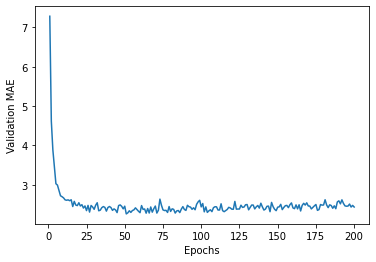

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It may be a little difficult to see the plot, due to scaling issues and relatively high variance. Let’s do the following:

* Omit the first 10 data points, which are on a different scale than the rest of the curve.
* Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

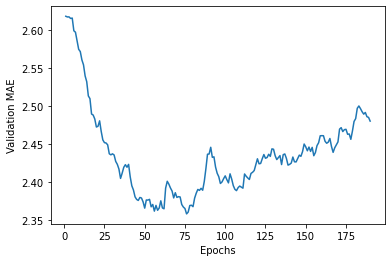

In [13]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## Training final model on all training data

In [14]:
model = build_model()
model.fit(train_data, train_targets,
          epochs = 50, batch_size = 16, verbose = 0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 19.0826 - mae: 2.7432


In [15]:
test_mae_score

2.743175983428955

Our predictions are off by about \$ 2,743.